# Milestone 2

---

Milestones ini dibuat guna mengevaluasi pembelajaran pada Hacktiv8 Data Science Full Time Program Phase 2 khususnya pada Deep Learning.

## Introduction

By [Rifky Aliffa](https://github.com/Penzragon)

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg/1200px-The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg)

### Dashboard

Untuk melihat halaman dashboard dari project, dapat ditekan pada tombol di bawah ini.

[![Deploy to Heroku](https://www.herokucdn.com/deploy/button.svg)](https://rifkyaliffa-wildfire.herokuapp.com/)

Atau

```
https://rifkyaliffa-wildfire.herokuapp.com/
```

### Dataset

Pada project ini dataset yang digunakan adalah berbagai macam gambar kebakaran dan api yang berjumlah 1461 gambar. Dataset dapat dilihat di [Kaggle](https://www.kaggle.com/datasets/phylake1337/fire-dataset).

### Objectives

**Milestones 2** ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

Dan tujuan utama dari project ini adalah untuk membuat model convolutional neural network yang mampu mendeteksi adanya **kebakaran hutan**.

## Import Libraries

Pada project ini library utama yang digunakan adalah **Pandas**, **NumPy**, **Matplotlib**, **Seaborn**, **Scikit-Learn**, **Tensorflow**, dan **Keras**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from sklearn.metrics import confusion_matrix
from PIL import Image
from io import BytesIO

Melakukan konfigurasi untuk mengizinkan tensorflow menggunakan memory GPU.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Data Loading

Pada bagian ini data gambar akan di load menggunakan `ImageDataGenerator`.

In [3]:
# Training data path
train_dir = 'dataset/fire_dataset/train/'

# Validation data path
test_dir = 'dataset/fire_dataset/test/'

In [4]:
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, width_shift_range=0.4, height_shift_range=0.4, shear_range=0.4, zoom_range=0.4)
valid_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=23, class_mode='binary')
valid_data = valid_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=23, class_mode='binary')

Found 1169 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


Terdapat **1169** file gambar pada training set dan **292** file gambar pada validation set.

## Exploratory Data Analysis

Pada bagian data exploration ini akan dilakukan sedikit eksplorasi pada dataset gambar yang digunakan.

In [5]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f'Found {len(dirnames)} folders with {len(filenames)} images in {dirpath}')

Found 2 folders with 0 images in dataset/fire_dataset/train/
Found 0 folders with 604 images in dataset/fire_dataset/train/fire
Found 0 folders with 565 images in dataset/fire_dataset/train/non_fire


Pada folder `train/` terdapat **1169** file gambar, dimana:
- **604** file gambar kebakaran
- **565** file gambar bukan kebakaran

In [6]:
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f'Found {len(dirnames)} folders with {len(filenames)} images in {dirpath}')

Found 2 folders with 0 images in dataset/fire_dataset/test/
Found 0 folders with 151 images in dataset/fire_dataset/test/fire
Found 0 folders with 141 images in dataset/fire_dataset/test/non_fire


Pada folder `test/` terdapat **292** file gambar, dimana:
- **151** file gambar kabakaran
- **141** file gambar bukan kebakaran

### Fire Image Samples

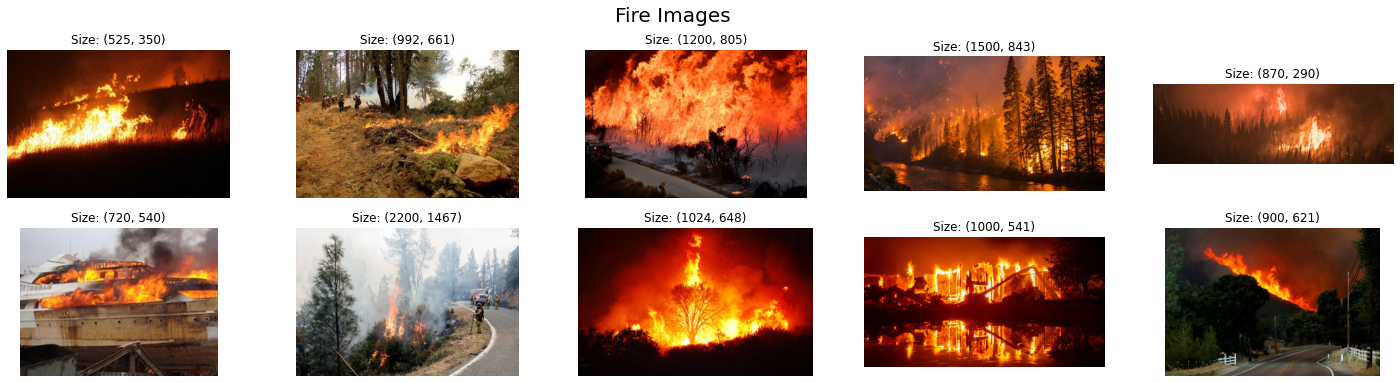

In [7]:
plt.figure(figsize=(25, 6))
plt.suptitle('Fire Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    random_img = random.sample(os.listdir(train_dir + 'fire/'), 1)
    img = image.load_img(train_dir + 'fire/' + random_img[0])
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Gambar-gambar diatas merupakan sample dari gambar kebakaran yang berada pada training set. Dapat dilihat setiap gambar memiliki ukuran **pixel yang berbeda-beda** dan jika dilihat kebanyakan dari gambar kebarakan didominasi oleh warna **merah** dan **orange**, gambar-gambar kebakaran ini juga cederung gambar yang gelap.

### Non Fire Image Samples

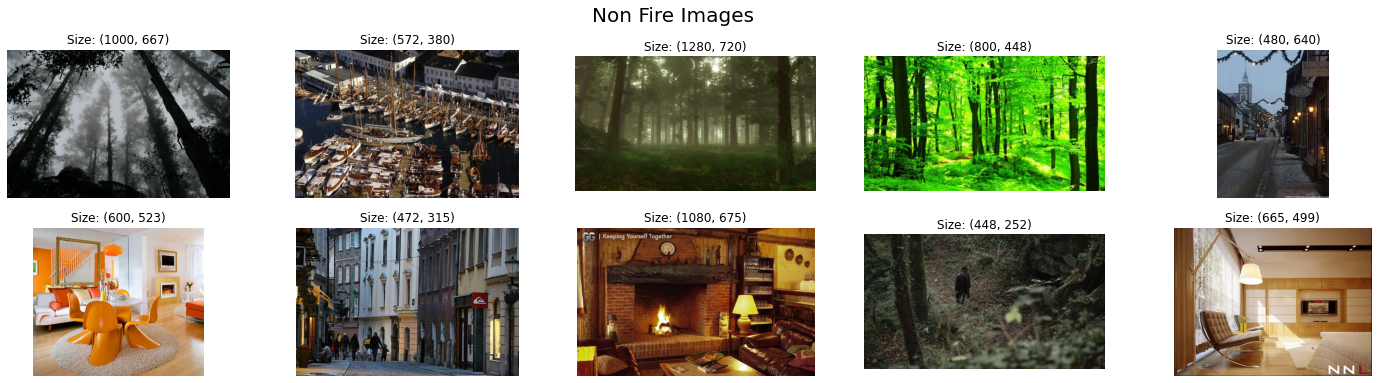

In [8]:
plt.figure(figsize=(25, 6))
plt.suptitle('Non Fire Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    random_img = random.sample(os.listdir(train_dir + 'non_fire/'), 1)
    img = image.load_img(train_dir + 'non_fire/' + random_img[0])
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Sama seperti gambar kebakaran, gambar-gambar yang bukan kebakaran ini memiliki ukuran pixel yang berbeda-beda namun tidak seperti gambar kebakaran, gambar bukan kebakaran ini memiliki gambar yang lebih cerah dan didominasi oleh warna **hijau** dan **biru**.

## Data Preprocessing

Saat melakukan pengambilan data gambar dari direktori pada bagian **Data Loading**, data sudah dilakukan preprocessing dengan menggunakan:
- `rescale` = 1./255
- `horizontal_flip` = True
- `vertical_flip` = True
- `rotation_range` = 90
- `width_shift_range` = 0.4
- `height_shift_range` =  0.4
- `shear_range` = 0.4
- `zoom_range` = 0.4

Proeses data preprocessing di atas dilakukan pada training setnya saja untuk menghindari overfitting pada model, sedangkan untuk validation setnya hanya dilakukan rescaling.

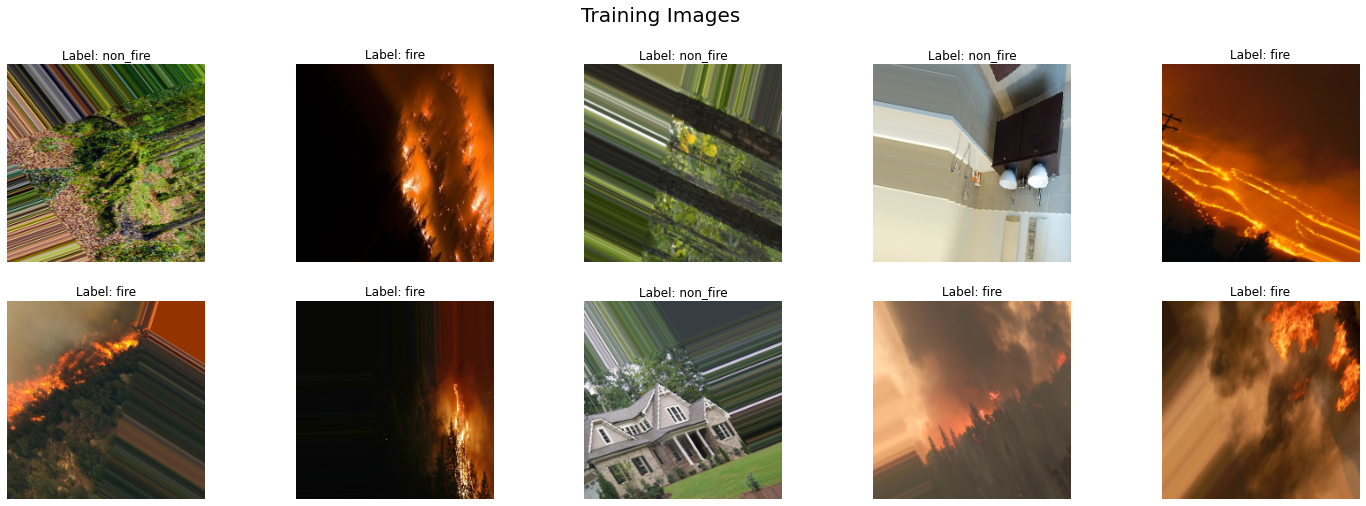

In [9]:
plt.figure(figsize=(25, 8))
plt.suptitle('Training Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Label: {"fire" if int(train_data[i][1][0]) == 0 else "non_fire"}')
    plt.axis('off')
plt.show()

Gambar-gambar di atas merupakan data training set yang telah melalui proses preprocessing, dapat dilihat gambar ini sudah memiliki ukuran pixel yang sama yaitu 224x224 pixel. Gambar juga sudah berubah bentuk ada yang dirotasi, dizoom, digeser, dan sebagainya.

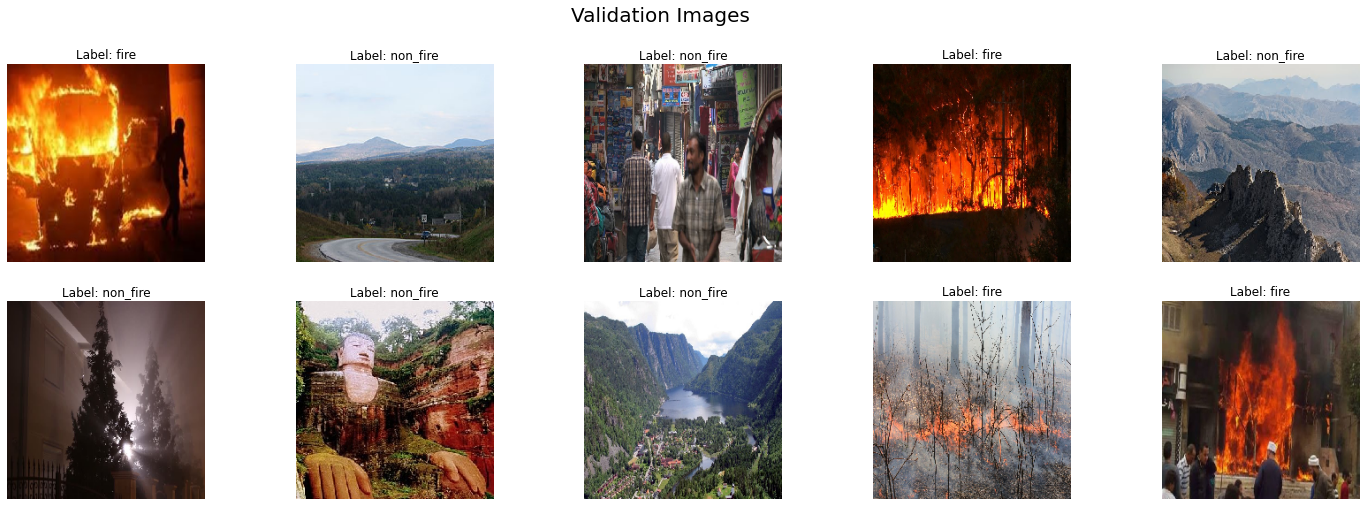

In [10]:
plt.figure(figsize=(25, 8))
plt.suptitle('Validation Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(valid_data[i][0][0])
    plt.title(f'Label: {"fire" if int(valid_data[i][1][0]) == 0 else "non_fire"}')
    plt.axis('off')
plt.show()

Sedangakan untuk gambar-gambar pada validation set diatas, jika dilihat tidak ada gambar yang diputar, digeser, ataupun dizoom ini karena pada validation set hanya dilakukan proses rescaling dan resizing saja.

## Model Definition

Pada bagian ini akan dibuat model **convolutional neural network** yang akan digunakan untuk mendeteksi kebakaran hutan. Model ini akan menggunakan 2 convolutional layer dan 2 pooling layer pada bagian feature extraction sedangkan pada bagian classification akan menggunakan 1 dense layer.

In [11]:
tf.keras.backend.clear_session()

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 16)                2

## Model Training

Setelah model di definisikan, selanjutnya model akan dicompile dengan menggunakan **Adam** optimizer dan loss function **binary crossentropy**. Lalu model akan dilatih dengan menggunakan data training sebanyak 25 epochs.

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=valid_data, verbose=0)

## Model Evaluation

Pada bagian ini akan dilakukan evaluasi terhadap model yang telah dilatih dengan melihat nilai accuracy dan loss yang dihasilkan.

In [15]:
print('-----------Training Results-----------')
train_results = model.evaluate(train_data, verbose=0)
print(f'Training Loss       : {train_results[0]:.4f}')
print(f'Training Accuracy   : {train_results[1]:.4f}')

print('-----------Validation Results-----------')
validation_results = model.evaluate(valid_data, verbose=0)
print(f'Validation Loss     : {validation_results[0]:.4f}')
print(f'Validation Accuracy : {validation_results[1]:.4f}')

-----------Training Results-----------
Training Loss       : 0.2454
Training Accuracy   : 0.9110
-----------Validation Results-----------
Validation Loss     : 0.3964
Validation Accuracy : 0.8390


### Loss and Accuracy Curves

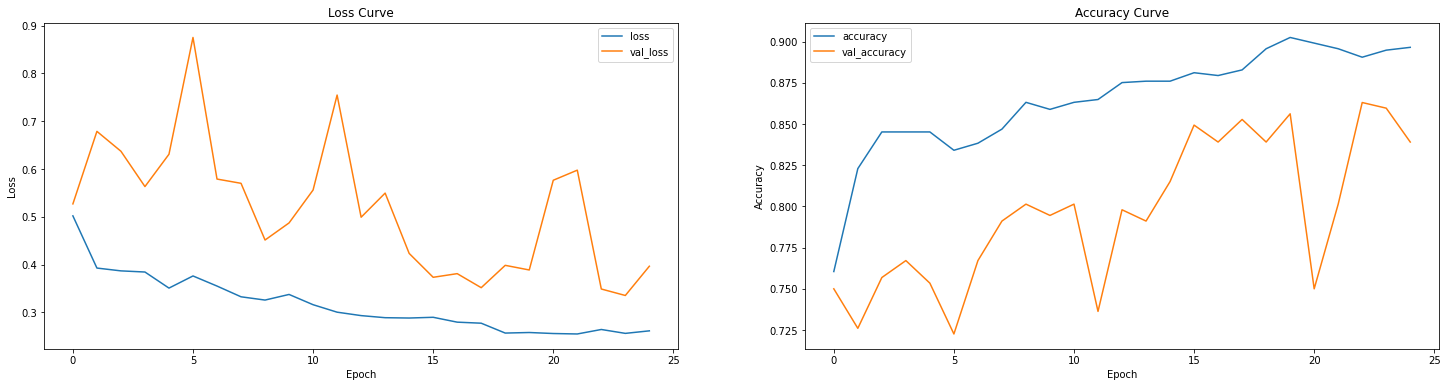

In [16]:
metrics = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

### Confusion Matrix

In [17]:
y_pred_train = tf.round(model.predict(train_data))
y_pred_test = tf.round(model.predict(valid_data))
y_train = train_data.classes
y_test = valid_data.classes

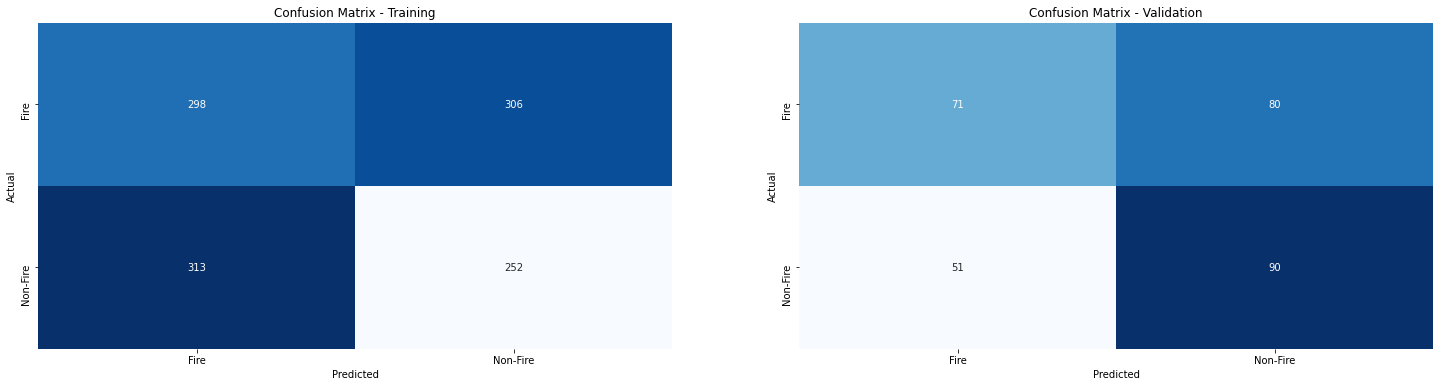

In [18]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
fig = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Analysis

Dari hasil evaluasi, model menghasilkan **accuracy 0.90** dengan **loss 0.22** pada training setnya sedangkan pada validation setnya model menghasilkan **accuracy 0.85** dengan **loss 0.43**. Dari hasil tersebut dapat diketahui bahwa model ini mengalami overfitting, hal ini juga dikonfirmasi oleh grafik loss dan accuracynya, dimana garis training loss dan validation loss berjauhan sama halnya dengan garis training accuracy dan validation accuracy. Jika dilihat dari confusion matrix pada training set model menghasilkan type 2 error (False Negative) yang besar.

## Model Improvement

Karena model pertama mengalami overfitting, maka pada bagian ini akan dilakukan improvement pada model dengan menggunakan transfer learning. Dimana pretrained model yang akan digunakan adalah model **Xception**.

In [34]:
tf.keras.backend.clear_session()

Mendownload model **Xception** yang menggunakan weight **imagenet** dan menggunakan **average pooling** pada pooling layernya.

In [35]:
# Load pretrained model
pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model.trainable = False

Model pretrained ini akan digunakan pada bagian feature extraction saja, sedangkan pada bagian classification akan digunakan 2 dense layer.

In [36]:
# Create the model
model2 = Sequential()
model2.add(pretrained_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [37]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,140,393
Trainable params: 278,913
Non-trainable params: 20,861,480
_________________________________________________________________


Model yang sudah diperbarui akan dicompile dengan menggunakan **Adamax** optimizer lalu dilatih dengan menambahkan callbacks early stopping untuk menghindari overfitting.

In [38]:
# Compile the model
model2.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_data, epochs=25, validation_data=train_data, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=0)

In [39]:
print('-----------Training Results-----------')
train_results = model2.evaluate(train_data, verbose=0)
print(f'Training Loss       : {train_results[0]:.4f}')
print(f'Training Accuracy   : {train_results[1]:.4f}')

print('-----------Validation Results-----------')
validation_results = model2.evaluate(valid_data, verbose=0)
print(f'Validation Loss     : {validation_results[0]:.4f}')
print(f'Validation Accuracy : {validation_results[1]:.4f}')

-----------Training Results-----------
Training Loss       : 0.1813
Training Accuracy   : 0.9230
-----------Validation Results-----------
Validation Loss     : 0.1274
Validation Accuracy : 0.9521


### Loss and Accuracy Curves

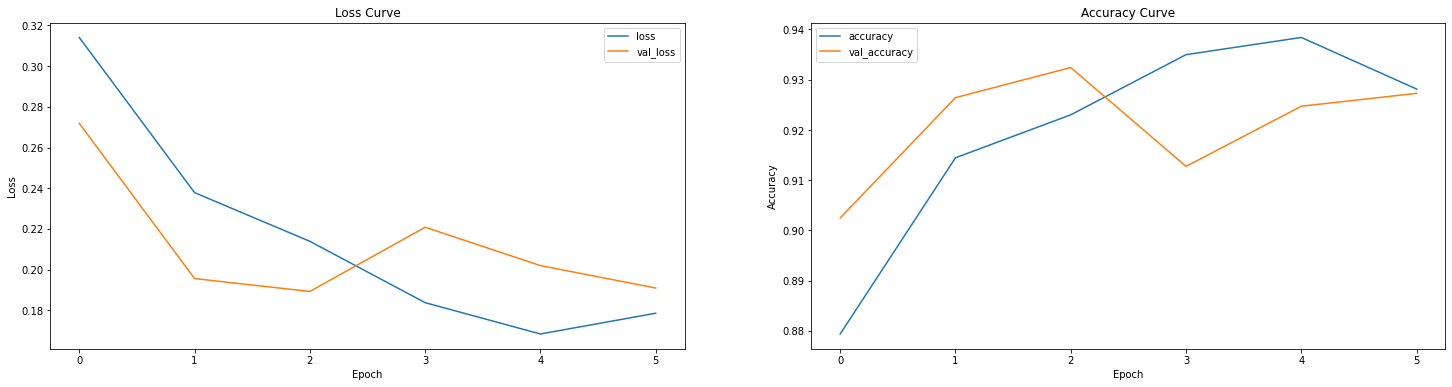

In [40]:
metrics = pd.DataFrame(history2.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

### Confusion Matrix

In [41]:
y_pred_train = tf.round(model2.predict(train_data))
y_pred_test = tf.round(model2.predict(valid_data))
y_train = train_data.classes
y_test = valid_data.classes

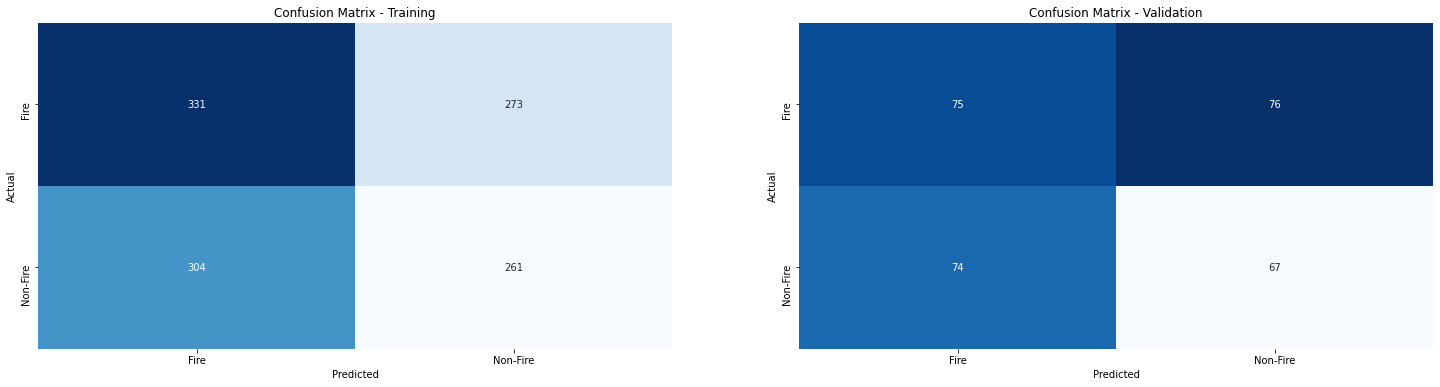

In [42]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
fig = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Analysis

Pada improvement model ini menggunakan model pretrained **Xception** pada bagian feature extraction dan pada bagian classification menggunakan 2 hidden layer dimana masing-masing layer memiliki 128 neuron . Dari hasil evaluasi model ini menghasilkan accuracy yang jauh lebih besar dan loss yang jauh lebih kecil daripada model pertama. Accuracy yang didapatkan adalah **0.95** dengan loss **0.13** pada training set dan pada validation set accuracy yang didapatkan adalah **0.93** dengan loss **0.22**.

Dari grafik loss dan accuracy jarak antara training dan validation sudah tidak sejauh model pertama, sehingga dapat diketahui bahwa model ini tidak mengalami overfitting. Dan pada confusion matrix, model ini memprediksi benar lebih banyak dari pada model pertama baik pada training maupun validation setnya.

## Model Saving

Pada bagian ini model dengan performa paling baik yang dalam kasus ini adalah model kedua (**improved**) akan disimpan menjadi `model.h5`.

In [43]:
model2.save('model.h5')

## Model Testing

Akan dilakukan pengujian pada model kedua dengan menggunakan 2 cara, yaitu dengan menggunakan data gambar pada local dan data gambar dari sebuah URL.

### From Local Storage

In [44]:
def load_img(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

In [45]:
img1 = load_img('img1.jpg')
img2 = load_img('img2.jpg')
img3 = load_img('img3.jpg')
img4 = load_img('img4.jpg')
img5 = load_img('img5.jpg')

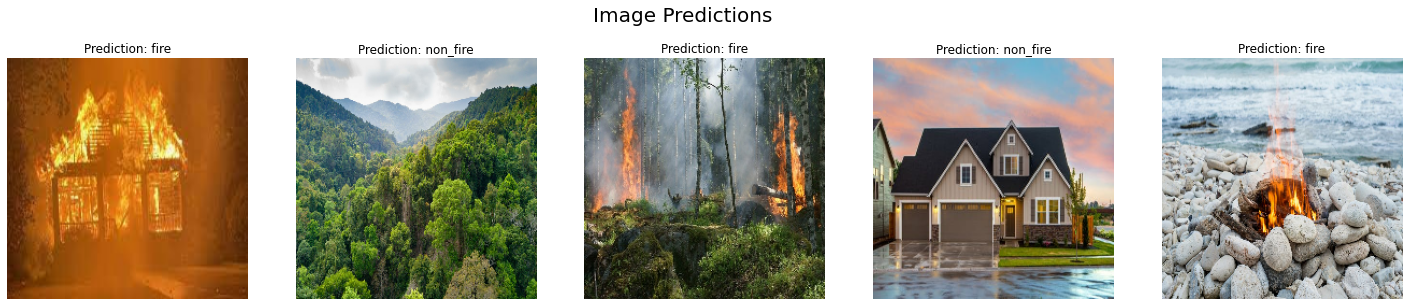

In [46]:
plt.figure(figsize=(25, 5))
plt.suptitle('Image Predictions', fontsize=20)
counter = 1
for i in [img1, img2, img3, img4, img5]:
    plt.subplot(1, 5, counter)
    res = int(tf.round(model2.predict(x=expand_dims(i, axis=0))))
    plt.imshow(i)
    plt.title(f"Prediction: {'fire' if res == 0 else 'non_fire'}")
    plt.axis('off')
    counter += 1
plt.show()  

### From URL

In [47]:
url = [
       "https://swaddle-wkwcb6s.stackpathdns.com/wp-content/uploads/2019/08/Amozon-forest-fire-Web-1-760x500.jpg",
       'https://miro.medium.com/max/1400/1*IC7_pdLtDMqwoqLkTib4JQ.jpeg',
       'https://www.globaltimes.cn/Portals/0/attachment/2021/2021-08-02/a93da530-4a35-4ff9-8af1-786ac98b5787.jpeg',
       'https://ichef.bbci.co.uk/news/976/cpsprodpb/32A5/production/_123456921_australianbushfire_gettyimages-1198540877.jpg',
       'https://static.dw.com/image/61024336_401.jpg'
       ]

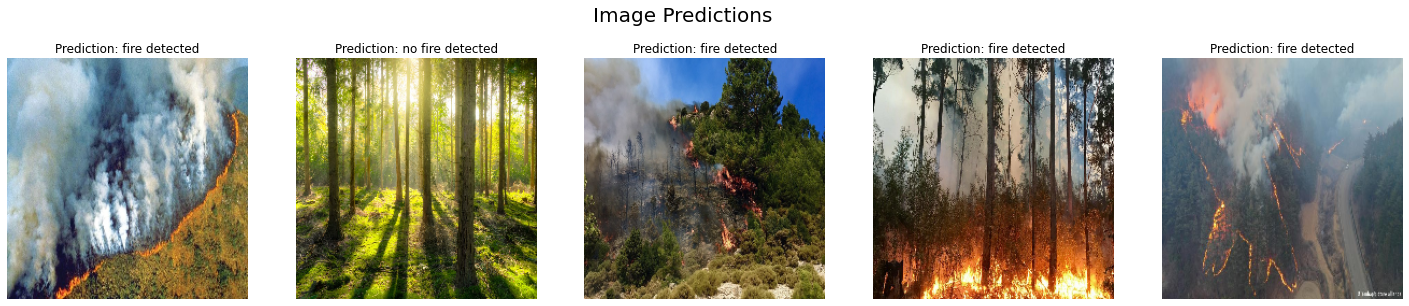

In [48]:
plt.figure(figsize=(25, 5))
plt.suptitle('Image Predictions', fontsize=20)
for i in range(len(url)):
    response = requests.get(url[i])
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    img = resize(img, size=[224, 224])
    img = img/255.
    plt.subplot(1, len(url), i+1)
    plt.imshow(img)
    res = int(tf.round(model2.predict(x=expand_dims(img, axis=0))))
    plt.title(f"Prediction: {'fire detected' if res == 0 else 'no fire detected'}")
    plt.axis('off')
plt.show()

## Conclusion

Kesimpulan yang dapat ditarik dari hasil EDA dan pemodelan menggunakan CNN ini adalah:

Dataset yang digunakan akan adalah dataset yang berisi gambar kebakaran dan juga api yang berjumlah **1461 gambar** dimana setiap gambarnya memiliki ukuran pixel yang berbeda-beda, mulai dari gambar berresolusi rendah hingga gambar berresolusi tinggi. Dari hasil EDA, gambar-gambar yang berlabel **fire** cenderung lebih gelap dan didominasi oleh warna **merah** dan **orange**, sedangkan untuk gambar-gambar yang berlabel **non_fire** cenderung lebih terang dan didominasi oleh warna **hijau** dan **biru**.

Karena ukuran gambar pada dataset ini berbeda-beda, maka sebelum dilakukan pemodelan, gambar-gambar akan dilakukan preprocessing terlebih dahulu dan menyamakan ukuran dari setiap gambarnya yaitu menjadi **224x224 pixel**. Lalu, dibuat model pertama dimana model ini menggunakan 2 convolutional layer dan 2 pooling layer pada bagian feature extractionnya sedangkan pada bagian classificationnya menggunakan 1 hidden layer dengan 64 neuron dan model ini dicompile dengan menggunakan optimizer **Adam**. Setelah model dilatih, model ini mengalami overfitting, dimana score akurasi yang didapatkan adalah **0.90** dengan loss **0.22** pada training set dan **0.85** dengan loss **0.43** pada validation set. Jika dilihat dari confusion matrixnya, model ini gagal dalam membedakan gambar kebakaran.

Oleh karena model pertama mengalami overfitting, maka akan dibuat model kedua dengan menggunakan transfer learning. Dimana pada bagian feature extraction model kedua ini akan menggunakan model pretrained Xception dan menggunakan weight imagenet dan average pooling pada pooling layernya lalu pada bagian classification akan menggunakan 2 hidden layer dengan 128 neuron pada masing-masing layer dan model akan dicompile menggunakan optimizer **Adamax** dan dilatih dengan menambahkan callbacks early stopping untuk menghindari overfitting.

Model kedua ini menghasilkan akurasi yang jauh lebih besar dari model pertama yaitu 0.95 pada training set dan 0.93 pada validation setnya, lalu model ini juga menghasilkan loss yang jauh lebih kecil daripada model pertama yaitu 0.13 pada training set dan 0.22 pada validation set. Dan jika dilihat dari confusion matrixnya, model ini dapat dengan baik membedakan mana gambar yang berlabel **fire** dan **non_fire**.